The purpose of this analysis is to adjust reported Covid case rates for vaccinations -- showing Covid cases as a share of *unvaccinated* people

This relies on two assumptions that are not strictly true, but useful: 
- Vaccinated people never catch Covid -- we know they can, but much less often than unvaccinated people
- People count as 'vaccinated' at the time of their final dose -- for two-dose vaccines this roughly splits the difference between when partial immunity is believed to take significant effect (two weeks after the first dose) and the generally agreed definition of 'full protection' (two weeks after the second dose) 

Subject to those assumptions, this will show the effective risk that an unvaccinated person will have a confirmed Covid case over time 

In [1]:
import pandas as pd
import numpy as np

import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import datetime

In [2]:
us = pickle.load(open('covid-19-data/us.p','rb'))
nj = pickle.load(open('covid-19-data/nj.p','rb'))
ny = pickle.load(open('covid-19-data/ny.p','rb'))

In [3]:
ny.tail()

,date,state,fips,cases,deaths,cases_1,cases_delta,cases_7,cases_100k
23807,2021-05-09,New York,36,2070603,52155,2068200.0,2403.0,2510.857143,12.909291
23862,2021-05-10,New York,36,2072264,52192,2070603.0,1661.0,2399.571429,12.337128
23917,2021-05-11,New York,36,2073713,52234,2072264.0,1449.0,2287.428571,11.760558
23972,2021-05-12,New York,36,2075757,52291,2073713.0,2044.0,2240.285714,11.518178
24027,2021-05-13,New York,36,2077961,52332,2075757.0,2204.0,2179.142857,11.203819


In [4]:
us = us[['date','cases_100k']]
nj = nj[['date','cases_100k']]
ny = ny[['date','cases_100k']]

us['date'] = pd.to_datetime(us['date'])
nj['date'] = pd.to_datetime(nj['date'])
ny['date'] = pd.to_datetime(ny['date'])

In [5]:
us_vax = pickle.load(open('owid/us_vax.p','rb'))
nj_vax = pickle.load(open('owid/nj_vax.p','rb'))
ny_vax = pickle.load(open('owid/ny_vax.p','rb'))

In [6]:
us_vax['date'] = pd.to_datetime(us_vax['date'])
nj_vax['date'] = pd.to_datetime(nj_vax['date'])
ny_vax['date'] = pd.to_datetime(ny_vax['date'])

In [7]:
# combine vaccination and case data
ny_adj = ny[['date','cases_100k']].merge(ny_vax[['date','vaccinated_100']], how='left', on='date').fillna(0)
nj_adj = nj[['date','cases_100k']].merge(nj_vax[['date','vaccinated_100']], how='left', on='date').fillna(0)
us_adj = us[['date','cases_100k']].merge(us_vax[['date','vaccinated_100']], how='left', on='date').fillna(0)

In [8]:
# adjust for vaccinations
ny_adj['cases_100k_adj'] = ny_adj['cases_100k']*100/(100-ny_adj['vaccinated_100'])
nj_adj['cases_100k_adj'] = nj_adj['cases_100k']*100/(100-nj_adj['vaccinated_100'])
us_adj['cases_100k_adj'] = us_adj['cases_100k']*100/(100-us_adj['vaccinated_100'])

In [9]:
df_adj = us_adj[['date','cases_100k_adj']]\
        .merge(ny_adj[['date','cases_100k_adj']], how='left', on='date', suffixes=('_us','_ny'))\
        .merge(nj_adj[['date','cases_100k_adj']], how='left', on='date', suffixes=('_us','_nj'))

df_adj.tail(15)

,date,cases_100k_adj_us,cases_100k_adj_ny,cases_100k_adj
464,2021-04-29,22.425335,29.172933,11.926458
465,2021-04-30,22.250605,28.311021,9.577399
466,2021-05-01,22.075018,28.273039,6.634574
467,2021-05-02,21.953409,27.077962,5.407252
468,2021-05-03,22.185091,26.537751,31.074308
469,2021-05-04,21.546427,25.428797,28.394288
470,2021-05-05,21.011542,24.941465,29.766427
471,2021-05-06,20.495534,23.768539,27.868733
472,2021-05-07,19.983180,22.395703,25.849019
473,2021-05-08,19.422859,21.633675,23.612754


In [10]:
df_adj.columns=['date','US','NY','NJ']

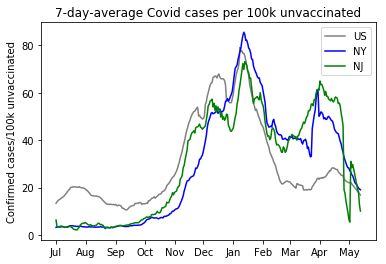

In [11]:
cutoff = datetime.strptime('Jul 1 2020', '%b %d %Y')
df_adj_plot = df_adj[df_adj['date']>=cutoff]

fig, ax = plt.subplots()
ax.plot(df_adj_plot.date, df_adj_plot.US, 'grey')
ax.plot(df_adj_plot.date, df_adj_plot.NY, 'blue')
ax.plot(df_adj_plot.date, df_adj_plot.NJ, 'green')

ax.legend()
ax.set_ylabel('Confirmed cases/100k unvaccinated')
ax.set_title('7-day-average Covid cases per 100k unvaccinated')
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

# there are clear restatements in the NY (late March) and NJ (late April) but I don't feel like cleaning them now